In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import os
from src import lib

# Introduction

- the adjusted pumps measure: the mean number of pumps for *banked trials*
- banked trials: trials in which there's no burst, the participant decides to bank the reward
- methodological concerns with the adjusted score:
    - reduced statistical power
    - may mis-measure the risk propensity

See an example below regarding how the adjusted pumps score creates measurement bias.

In [2]:
def plot_banked_burst(df):
    fig, axs = plt.subplots(2, 2, sharey=True, figsize=(8,4))

    c = ["yellow", "blue"]
    cond = ["not ", ""]

    for ic, cn in enumerate(cond):
        for i, n in enumerate(["_A", "_B"]):
            avg_bank = df.query(f"{cn}burst{n}")["person"+n]
            avg_bank.hist(
                bins=np.arange(0, 13) - 0.4,  # slightly reduce bin width
                # edgecolor='black',
                rwidth=0.8,  # reduces the width of bars
                color=c[i],
                ax = axs[ic,i]
            )
            axs[ic,i].set_xticks(np.arange(0, 13))
            axs[ic,i].set_xlim(-0.5, 12.5)
            axs[ic,i].grid(False)

    fig.text(0.04, 0.7, 'Banked', va='center', rotation='vertical', fontsize=11)
    fig.text(0.04, 0.25, 'Burst', va='center', rotation='vertical', fontsize=11)

    fig.text(0.3, 0.02, "Pumps for Person A", ha='center', va='center', fontsize=11)
    fig.text(0.72, 0.02, "Pumps for Person B", ha='center', va='center', fontsize=11)

    fig.suptitle("Distribution of Number of Pumps", fontsize=16)
    plt.show()

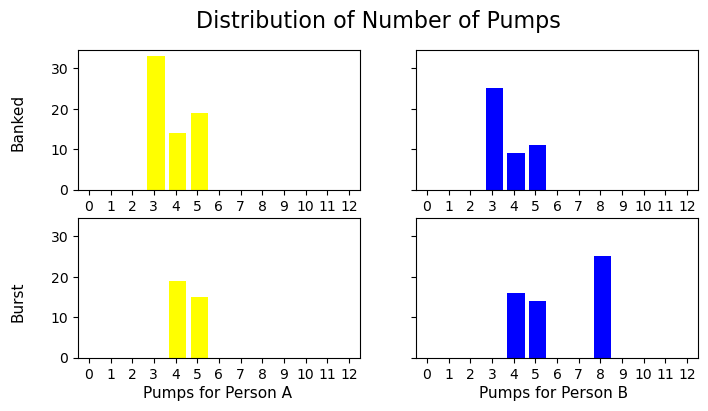

In [3]:
experiment = np.random.permutation(np.concatenate((np.repeat(4, 50), np.repeat(8, 50))))
person_A = np.random.permutation(np.concatenate((np.repeat(3, 33), np.repeat(4, 33), np.repeat(5, 34))))
person_B = np.random.permutation(np.concatenate((np.repeat(3, 25), np.repeat(4, 25), np.repeat(5, 25), np.repeat(8, 25))))
df = pd.DataFrame(columns=["experiment", "person_A", "person_B"])
df["experiment"] = experiment
df["person_A"] = person_A
df["person_B"] = person_B
df["burst_A"] = df.apply(lambda x: x["person_A"] >= x["experiment"], axis=1)
df["burst_B"] = df.apply(lambda x: x["person_B"] >= x["experiment"], axis=1)

plot_banked_burst(df)

Alternatives to adjusted score:
- automatic BART: indicate n_pump in the beginning of the trial, but this is fundamentally different ito. cognitive processes: e.g. one decision vs. multiple decisions
- use trials with limitless pumps: leads to large variation
- avoid counting pumps: use number of explosions

Offered alternative: use **censoring**


# Censoring

- censored data: external constraints prevent the true value of an observation from being fully known
- note the difference:
    - censoring involves limitations in the measurement of true values
    - truncation involves limits on the values themselves

observed number of pumps is right censored (e.g. it is censored only if the value was to be greater than the observation)

**goal**: provide a cognitive process model that uses censoring to measure the distribution of intended pumps
**assumptions**:
- Gaussian distribution of the underlying distribution of intentions, truncated to be non-negative
- where mean is the **risk propensity**
- and the variability is the **behavioral consistency**

## Censoring vs Truncation

Below we plot several distributions to illustrate the difference:
$$
\begin{align*}
y_t &\sim \text{Gaussian}(1, 1) \tag{1}
\\
y_t' &\sim Gaussian_+(\rho_{p}, \beta_{p}) \tag{2}
\\
y_t &= \begin{cases} y_t' &\text{if} \quad y_t' <b_t \\ b_t &\text{if} \quad y_t' \geq b_t \end{cases} \tag{3}
\end{align*}
$$

1. Normal distribution 
2. The positive-normal (truncated) distribution
3. Censored distribution, based on (2), and a censoring value of $b_t$ (baloon burst)

where the model will incorporate:
- $y_{t}'$ is the *intended* number of pumps that participant $p$ intended to make on $t^{th}$ trial
- $\rho_{p}$: risk propensity
- $\beta_{p}$: behavioral consistency

Sampling: [cs_n, cs_tn, hn, n, truncated_normal]


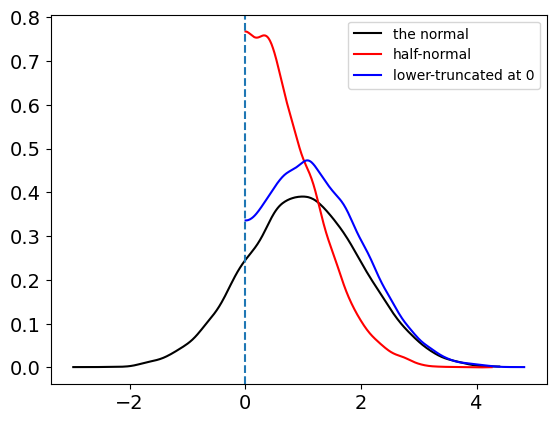

In [4]:
with pm.Model() as m:
    # define a Gaussian
    a_normal = pm.Normal("n", 1, 1)
    
    # the trucated normal, only the positive values 
    normal_dist = pm.Normal.dist(mu=1.0, sigma=1.0)
    truncated_normal = pm.Truncated("truncated_normal", normal_dist, lower=0)
    
    # the censored normal
    cs_normal = pm.Censored("cs_n", normal_dist, lower=0, upper=3)
    
    # the truncated and censored normal
    truncated_normal_dist = pm.Truncated.dist(normal_dist, lower=0)
    cs_truncated_normal = pm.Censored("cs_tn", truncated_normal_dist, lower=None, upper=3)

    # the halfnormal
    half_normal = pm.HalfNormal("hn", 1)

with m:
    idata = pm.sample_prior_predictive(samples=10000)

az.plot_dist(idata.prior.stack(samples=("chain", "draw")).n, color='k', label="the normal")
az.plot_dist(idata.prior.stack(samples=("chain", "draw")).hn, color='r', label="half-normal")
ax=az.plot_dist(idata.prior.stack(samples=("chain", "draw")).truncated_normal, color='b', label="lower-truncated at 0")
ax.axvline(x=0, linestyle="--");

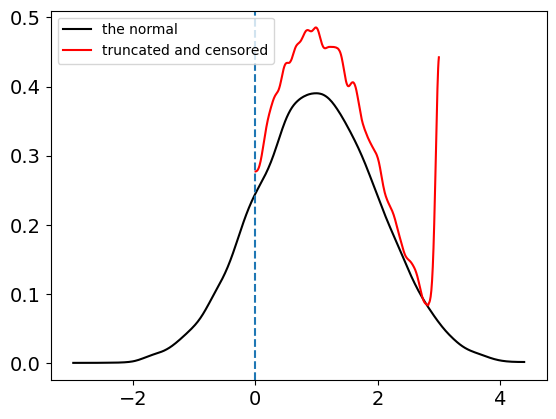

In [5]:
az.plot_dist(idata.prior.stack(samples=("chain", "draw")).n, color='k', label="the normal")
ax = az.plot_dist(idata.prior.stack(samples=("chain", "draw")).cs_tn, color='r', label="truncated and censored")
ax.axvline(x=0, linestyle="--");

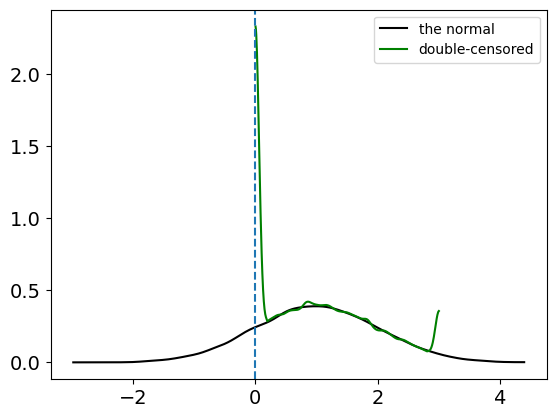

In [6]:
az.plot_dist(idata.prior.stack(samples=("chain", "draw")).n, color='k', label="the normal")
ax = az.plot_dist(idata.prior.stack(samples=("chain", "draw")).cs_n, color='g', label="double-censored")
ax.axvline(x=0, linestyle="--");

# The Model

Assumptions:
- on each trial the participants' intended number of pumps is sampled from a truncated Gaussian distribution with mean $\rho_p$ and standard deviation $\beta_p$ for participant $p$
- number of pumps = non-negative integer = truncated Gaussian rounded to the nearest whole number
- the intended number of pumps for participant $p$ on the trial $t$: $y'_t$
- $b_t$: the right censoring value, i.e. number of pumps it takes for the balloon to burst on trial $t$
- $\rho_i$ and $\beta_i$: priors for participant $i$
$$
\begin{align*}
y'_t &\sim \lfloor Gaussian_+(\rho_{p_t}, \beta_{p_t}) \rceil
\\
y_t &= \begin{cases} y_t' &\text{if} \quad y_t' <b_t \\ b_t &\text{if} \quad y_t' \geq b_t \end{cases}
\\
\rho_i &\sim Gaussian_+(0,100) 
\\
\beta_i &\sim Gaussian_+(0,100)

\end{align*}
$$

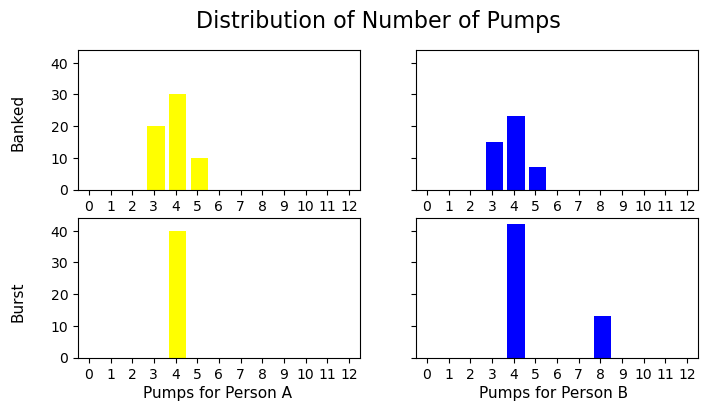

In [7]:
# load demo data
osf_folder = "../coon_osf_files"
demo_file = "BARTDemo.csv"
df0 = pd.read_csv(os.path.join(osf_folder, "data", demo_file))
df0["outcome"] = df0.apply(lambda x: x[" y"] >= x[" burst"], axis=1)
df0["trial"] = np.tile(np.arange(100), 2)

# make some adjustments for plotting
df1 = df0.pivot_table(columns="participant", index="trial")
df1 = df1.drop(columns=[(" burst", 1)])
df1.columns = [col if isinstance(col, str) else f"{col[0].strip()}_{col[1]}" for col in df1.columns]
df1 = df1.rename(columns={
    'burst_2': 'experiment',
    'y_1': 'person_A',
    'y_2': 'person_B',
    'outcome_1': 'burst_A',
    'outcome_2': 'burst_B'
})
df1 = df1.astype({'burst_A': bool, 'burst_B': bool})

# plot 
plot_banked_burst(df1)

In [8]:
df0[" y"] = df0[" y"].astype(float)
df0[" burst"] = df0[" burst"].astype(float)
df0["participant"] = df0["participant"] - 1

In [9]:
with pm.Model() as m_demo:
    rho = pm.LogNormal('rho', 0, 1., shape=2)
    beta = pm.Exponential('beta', 1., shape=2)

    intended = pm.Normal.dist(mu=rho[df0["participant"]], sigma=beta[df0["participant"]])

    pump = pm.Censored(
        "pump",
        intended,
        lower=None,
        upper=df0[" burst"],
        observed=df0[" y"],
    )


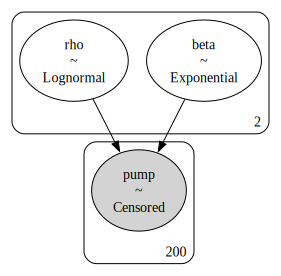

In [10]:
pm.model_to_graphviz(m_demo)

In [11]:
with m_demo:
    idata = pm.sample()

idata_posterior = idata.posterior.stack(sample=("chain", "draw"))

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rho, beta]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


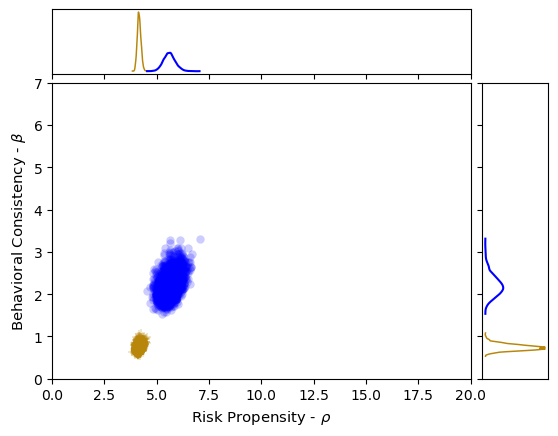

In [13]:
ax = az.plot_pair(
    idata,
    marginals=True,
    group='posterior',
    var_names=["rho", "beta"],
    kind='scatter',
    textsize=10,
    scatter_kwargs={'marker': 'P', 'facecolors': 'darkgoldenrod', 'alpha': 0.2},
    marginal_kwargs={"color": "darkgoldenrod"},
    coords={"rho_dim_0": 0,
            "beta_dim_0": 0,}
)

for i in np.arange(len(ax)):
    ax[i][0].set_xlim([0, 20])
ax[1][0].set_ylim([0, 7])

az.plot_pair(
    idata,
    marginals=False,
    group='posterior',
    var_names=["rho", "beta"],
    kind='scatter',
    textsize=10,
    scatter_kwargs={'marker': 'o', 'facecolors': 'blue', 'alpha': 0.2 },
    coords={"rho_dim_0": 1,
            "beta_dim_0": 1,},
    ax=ax[1, 0]
)

az.plot_dist(idata_posterior.sel(beta_dim_0=1).beta, color='blue', rotated=True, ax=ax[1,1])
az.plot_dist(idata_posterior.sel(rho_dim_0=1).rho, color='blue', rotated=False, ax=ax[0,0])

ax[1, 0].set_ylabel(r"Behavioral Consistency - $\beta$")
ax[1, 0].set_xlabel(r"Risk Propensity - $\rho$")

plt.show()

## Model Posteriors

for person A
- inference is relatively certain
- consistently intending to make close to four pumps on every trial

for person B
- much more uncertain
- intending to make an average of around six pumps
- high variability across trials

In [12]:
print(
    "person A: \n",
    "- risk propensity 95%HDI: ", az.hdi(idata_posterior.sel(rho_dim_0=0).rho.values, hdi_prob=0.95), "\n",
    "- behavioral consistency 95%HDI: ", az.hdi(idata_posterior.sel(beta_dim_0=0).beta.values, hdi_prob=0.95), "\n",
    "person B: \n",
    "- risk propensity 95%HDI: ", az.hdi(idata_posterior.sel(rho_dim_0=1).rho.values, hdi_prob=0.95), "\n",
    "- behavioral consistency 95%HDI: ", az.hdi(idata_posterior.sel(beta_dim_0=1).beta.values, hdi_prob=0.95), "\n",
    )

person A: 
 - risk propensity 95%HDI:  [3.98630724 4.32417265] 
 - behavioral consistency 95%HDI:  [0.60978664 0.87927824] 
 person B: 
 - risk propensity 95%HDI:  [5.08792154 6.19087038] 
 - behavioral consistency 95%HDI:  [1.77014561 2.71057938] 



### Posterior Predictives

In [13]:
posterior = idata.posterior
n_samples = posterior.sizes["chain"] * posterior.sizes["draw"]

# stack chain and draw to get flat samples
posterior_stacked = posterior.stack(sample=("chain", "draw"))

rho_samples = posterior_stacked["rho"].values
beta_samples = posterior_stacked["beta"].values

pp_A = np.round(np.random.normal(rho_samples[0,:], beta_samples[0, :]))
pp_B = np.round(np.random.normal(rho_samples[1,:], beta_samples[1, :]))

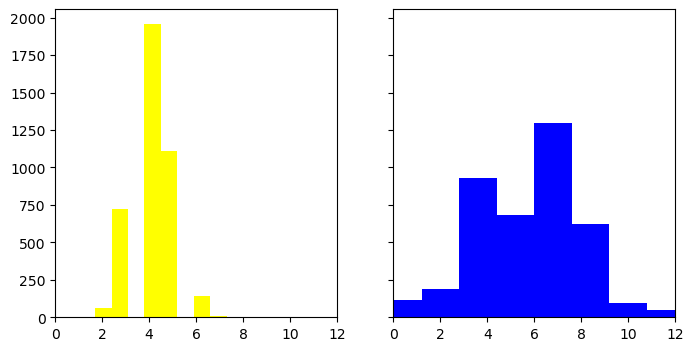

In [14]:

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(8,4))
c = ["yellow", "blue"]
axs[0].hist(pp_A, color=c[0])
axs[1].hist(pp_B, color=c[1])
axs[0].set_xlim([0, 12])
axs[1].set_xlim([0, 12]);

## Parameter Recovery

Here we assing values to latent variables and generate data, and assess the capacity of a model in recovering those values.

In [15]:
n_participants = 100
n_trials = 50
# following values are based on Guan et al. 2020
sim_params = {
    "p_burst": [0.1, 0.2],
    "mu_rho": [7, 5],
    "sigma_rho": [5, 2],
    "mu_beta": [3, 2],
    "sigma_beta": [2, 1]
}

The following cell simulates data untill the dataset is acceptable. The criteria for this is having at least two different pump values for banked trials. Otherwise the inference is problematic. Below a seed value is provided that satisfies this criteria within allowed resample runs.

In [16]:
sim_data = {}
param_vals = {}
recover_idata = {}
for ie, environment in enumerate(["A", "B"]):
    num_bad = 1
    i_run = 1
    allowed_resample = 100
    while (num_bad != 0):
        df_pr, df_param_vals = lib.simulate_data(
            sim_params["mu_rho"][ie],
            sim_params["sigma_rho"][ie],
            sim_params["mu_beta"][ie],
            sim_params["sigma_beta"][ie],
            n_participants,
            sim_params["p_burst"][ie],
            n_trials,
            random_seed=120
        );
        df_pr["banked"] = df_pr.apply(lambda x: x["y"] < x["burst"], axis=1, result_type="expand")
        num_bad = (df_pr.query("banked").groupby("participant")["y"].unique().apply(lambda x: len(x))<=2).sum()
        i_run+=1
        assert i_run < allowed_resample, "reached resampling limit"
    sim_data[environment] = df_pr

Sampling: [beta, pump, rho]
Sampling: [beta, pump, rho]
Sampling: [beta, pump, rho]
Sampling: [beta, pump, rho]


In [17]:
for ie, environment in enumerate(["A", "B"]):
    recovered_idata = lib.recover_parameters(df_pr)
    recover_idata[environment] = recovered_idata
    df_param_vals["rho_hat"] = az.summary(recovered_idata, var_names="rho")[
        "mean"
    ].values
    df_param_vals["beta_hat"] = az.summary(recovered_idata, var_names="beta")[
        "mean"
    ].values
    param_vals[environment] = df_param_vals

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rho, beta]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 41 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rho, beta]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.


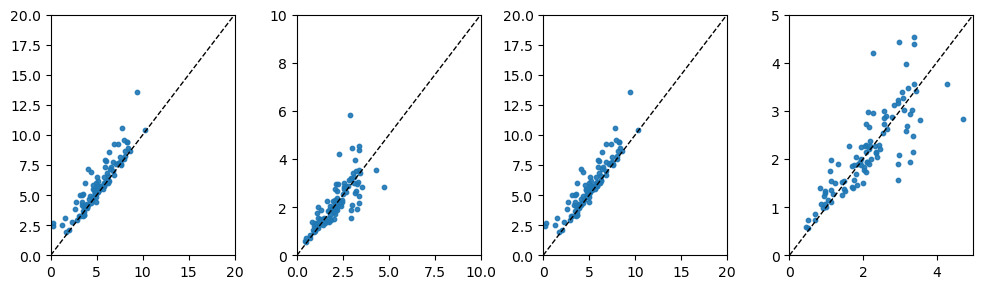

In [18]:
fig, axs = plt.subplots(1, 4, figsize=(10, 3))
plt.tight_layout()

scatter_kwargs = dict(s=10, alpha=0.9)

axs[0].scatter(param_vals["A"]["rho"].values, param_vals["A"]["rho_hat"].values, **scatter_kwargs)
axs[1].scatter(param_vals["A"]["beta"].values, param_vals["A"]["beta_hat"].values, **scatter_kwargs)
axs[2].scatter(param_vals["B"]["rho"].values, param_vals["B"]["rho_hat"].values, **scatter_kwargs)
axs[3].scatter(param_vals["B"]["beta"].values, param_vals["B"]["beta_hat"].values, **scatter_kwargs)
axs[0].set_xlim([0, 20])
axs[0].set_ylim([0, 20])
axs[2].set_xlim([0, 20])
axs[2].set_ylim([0, 20])
axs[1].set_xlim([0, 10])
axs[1].set_ylim([0, 10])
axs[3].set_xlim([0, 5])
axs[3].set_ylim([0, 5])

for ax in axs:
    x_min, x_max = ax.get_xlim()
    y_min, y_max = ax.get_ylim()
    line_min = min(x_min, y_min)
    line_max = max(x_max, y_max)
    ax.plot([line_min, line_max], [line_min, line_max], 'k--', linewidth=1)
    ax.set_xlim(line_min, line_max)
    ax.set_ylim(line_min, line_max)

In [21]:
az.summary(recover_idata["A"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
rho[0],5.561,0.445,4.711,6.358,0.006,0.008,5874.0,2864.0,1.0
rho[1],7.862,1.207,5.925,10.237,0.019,0.027,5089.0,2885.0,1.0
rho[2],5.751,0.603,4.695,6.909,0.009,0.011,5252.0,2756.0,1.0
rho[3],13.476,2.921,8.996,19.177,0.043,0.059,5975.0,3217.0,1.0
rho[4],5.460,0.645,4.310,6.607,0.009,0.013,5670.0,2918.0,1.0
...,...,...,...,...,...,...,...,...,...
beta[95],0.556,0.129,0.349,0.792,0.002,0.003,6869.0,2762.0,1.0
beta[96],3.016,0.764,1.827,4.467,0.013,0.019,4817.0,2215.0,1.0
beta[97],0.737,0.109,0.557,0.950,0.001,0.002,7134.0,3091.0,1.0
beta[98],2.121,0.404,1.393,2.838,0.006,0.008,6489.0,3150.0,1.0


In [22]:
az.summary(recover_idata["B"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
rho[0],5.554,0.429,4.733,6.352,0.006,0.007,6450.0,2836.0,1.0
rho[1],7.841,1.234,5.755,10.040,0.018,0.034,5707.0,2784.0,1.0
rho[2],5.738,0.612,4.689,6.895,0.009,0.013,6138.0,2786.0,1.0
rho[3],13.523,2.861,8.966,18.765,0.042,0.055,6169.0,2851.0,1.0
rho[4],5.441,0.632,4.393,6.712,0.009,0.011,5684.0,3006.0,1.0
...,...,...,...,...,...,...,...,...,...
beta[95],0.560,0.127,0.348,0.793,0.002,0.003,7255.0,2643.0,1.0
beta[96],3.004,0.750,1.840,4.427,0.012,0.016,5344.0,2765.0,1.0
beta[97],0.734,0.101,0.571,0.935,0.001,0.002,6765.0,3603.0,1.0
beta[98],2.143,0.432,1.456,3.013,0.006,0.009,6305.0,2941.0,1.0
